In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
import scipy
from matplotlib import pyplot as plt

from harmonic_balance import arclength_continuation as alc
from harmonic_balance import aft, freq, solve, utils

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
alpha = 1
beta = 1
delta = 1
gamma = 1

omega = 2
n = 1

m1 = 1
c1 = delta
k1 = alpha

M = np.array([[m1]])
C = np.array([[c1]])
K = np.array([[k1]])

ks = (1,)
dofs = (0,)
is_cosines = (1,)
coefficients = (gamma,)

factor = beta
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 256

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Define domain

In [ ]:
t0, tf = tlim = 0, 2 * np.pi / omega
tn = NH * 2 + 1
tls = np.linspace(*tlim, tn, endpoint=False)

total_periods = 10
period = 2 * np.pi / omega
ti_t0, ti_tf = ti_tlim = t0, total_periods * period
ti_tls = np.linspace(*ti_tlim, tn * total_periods, endpoint=False)

## Run time integration

In [ ]:
A = freq.get_A(omega, NH, M, C, K)
z_linear = freq.solve_linear_system(A, b_ext)
zp_linear = freq.get_derivative(omega, z_linear, NH, n)

zz_linear = utils.extract_dofs_freq(z_linear, n)
zzp_linear = utils.extract_dofs_freq(zp_linear, n)

xx0 = scipy.fft.ifft(
    scipy.fft.ifftshift(zz_linear, axes=1), axis=1, norm=freq.FFT_NORM
).real
xxp0 = scipy.fft.ifft(
    scipy.fft.ifftshift(zzp_linear, axes=1), axis=1, norm=freq.FFT_NORM
).real

x0 = xx0[:, 0]
xp0 = xxp0[:, 0]
y0 = np.concat((x0, xp0))


def ode(t, y, *args):
    omega, M, C, K, f_ext, f_nl = args

    x = y[:n]
    xp = y[n:]

    xpp = np.linalg.inv(M) @ (
        -C @ xp - K @ x - f_nl(x, xp, 1) + f_ext(omega, t)
    )
    return np.concat((xp, xpp))


f_ext = utils.get_f_ext(n, ks, dofs, is_cosines, coefficients)
args = (omega, M, C, K, f_ext, f_nl)
sol = scipy.integrate.solve_ivp(
    ode,
    ti_tlim,
    y0,
    t_eval=ti_tls,
    args=args,
    atol=1e-10,
    rtol=1e-10,
    method="DOP853",
)

ti_xx = sol.y[:n][:, -tn:]
ti_xxp = sol.y[n:][:, -tn:]

ti_zz = scipy.fft.fftshift(
    scipy.fft.fft(ti_xx, axis=1, norm=freq.FFT_NORM), axes=1
)
ti_z = utils.combine_dofs_freq(ti_zz)

ti_R = alc.get_R(ti_z, omega, A, f_nl, b_ext, NH, n, N)

## Run harmonic balance

In [ ]:
initial_guess = ti_z
# initial_guess = z_linear
hb_z, hb_R, converged, iters = solve.solve_nonlinear(
    omega,
    initial_guess,
    A,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    1e-11,
    max_iter=200,
)
hb_zp = freq.get_derivative(omega, hb_z, NH, n)

hb_zz = utils.extract_dofs_freq(hb_z, n)
hb_zzp = utils.extract_dofs_freq(hb_zp, n)

hb_xx = scipy.fft.ifft(
    scipy.fft.ifftshift(hb_zz, axes=1), axis=1, norm=freq.FFT_NORM
).real
hb_xxp = scipy.fft.ifft(
    scipy.fft.ifftshift(hb_zzp, axes=1), axis=1, norm=freq.FFT_NORM
).real

print(f"Converged:  {converged}")
print(f"Iterations: {iters}")

Converged:  True
Iterations: 1


## Plot

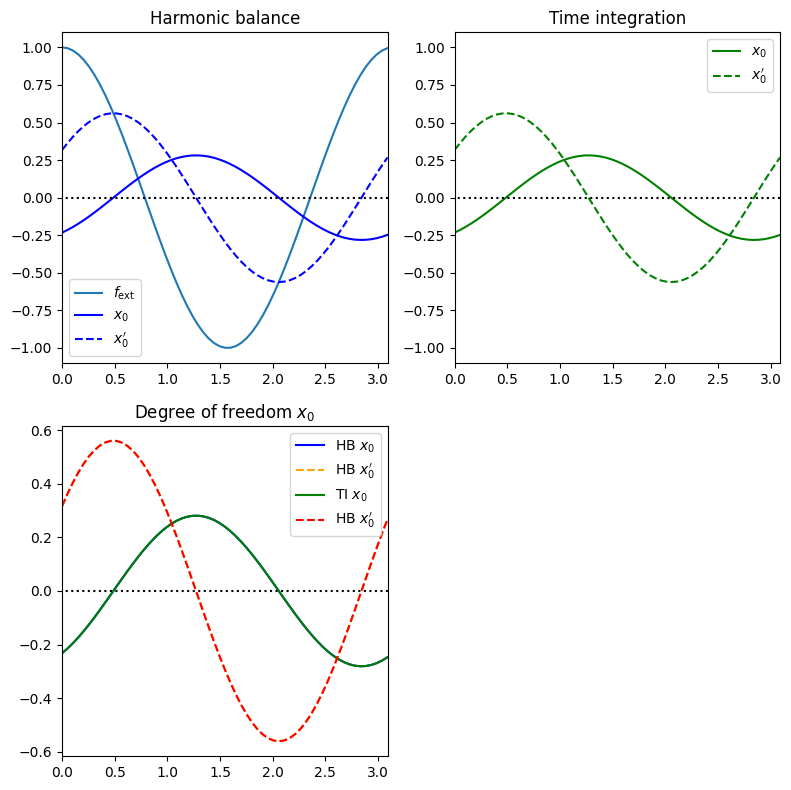

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ("blue", "orange")
ti_colors = ("green", "red")
[ax.set_xlim(tls[0], tls[-1]) for ax in axs.ravel()]

# External force
ax = axs[0, 0]
ax.plot(
    tls,
    scipy.fft.ifft(
        scipy.fft.ifftshift(b_ext.toarray()), norm=freq.FFT_NORM
    ).real,
    label=r"$f_\text{ext}$",
)

# Harmonic balance
ax = axs[0, 0]
ax.set_title("Harmonic balance")

names = [rf"x_{i}" for i in range(n)]
for xx, xxp, color, name in zip(hb_xx, hb_xxp, colors, names):
    ax.plot(tls, xx, color=color, label=rf"${name}$")
    ax.plot(tls, xxp, color=color, label=rf"${name}'$", ls="--")
ax.legend()

# Time integration
ax = axs[0, 1]
ax.set_title("Time integration")

for xx, xxp, color, name in zip(ti_xx, ti_xxp, ti_colors, names):
    ax.plot(tls, xx, color=color, label=rf"${name}$")
    ax.plot(tls, xxp, color=color, label=rf"${name}'$", ls="--")
ax.legend()
ax.set_ylim(axs[0, 0].get_ylim())

# Compare for each degree of freedom
for i in range(n):
    ax = axs[1, i]
    ax.set_title(rf"Degree of freedom ${names[i]}$")
    ax.plot(tls, hb_xx[i], color=colors[0], label=rf"HB ${names[i]}$")
    ax.plot(
        tls, hb_xxp[i], color=colors[1], label=rf"HB ${names[i]}'$", ls="--"
    )
    ax.plot(tls, ti_xx[i], color=ti_colors[0], label=rf"TI ${names[i]}$")
    ax.plot(
        tls, ti_xxp[i], color=ti_colors[1], label=rf"HB ${names[i]}'$", ls="--"
    )
    ax.legend()

[
    ax.hlines(*axs[0, 0].get_xlim(), 0, colors="black", ls=":")
    for ax in axs.ravel()
]

plt.delaxes(axs[-1, -1])
fig.tight_layout()
plt.show()

In [ ]:
print("Relative errors")
print(f"TI: {solve.get_rel_error(ti_R, ti_z)}")
print(f"HB: {solve.get_rel_error(hb_R, hb_z)}")

Relative errors
TI: 4.0742872939023455e-06
HB: 6.383684555401113e-17


Absolute differences in Fourier coefficients
[1.16248935e-10 1.09816518e-10 1.03964266e-10 1.24337729e-10
 1.49451345e-10 1.67442966e-10 1.88986588e-10 2.20856031e-10
 2.81037236e-10 3.90197246e-10 5.88382738e-10 1.43420084e-09
 2.18312937e-09 1.43420084e-09 5.88382738e-10 3.90197246e-10
 2.81037236e-10 2.20856031e-10 1.88986588e-10 1.67442966e-10
 1.49451345e-10 1.24337729e-10 1.03964266e-10 1.09816518e-10] 

TI coefficients
[1.16248935e-10 1.09816516e-10 1.03964266e-10 1.24350047e-10
 1.49451345e-10 1.91955570e-10 1.88986588e-10 4.68426164e-08
 2.81037236e-10 7.85187327e-05 5.88382738e-10 1.40594023e-01
 2.18312937e-09 1.40594023e-01 5.88382738e-10 7.85187327e-05
 2.81037236e-10 4.68426164e-08 1.88986588e-10 1.91955570e-10
 1.49451345e-10 1.24350047e-10 1.03964266e-10 1.09816516e-10] 

HB coefficients
[9.33263229e-22 9.45953262e-18 1.02422470e-21 1.61430695e-14
 1.47574187e-21 2.75352812e-11 7.68321112e-21 4.68754300e-08
 1.97787053e-20 7.85191109e-05 3.03252698e-19 1.40594024e-01
 6

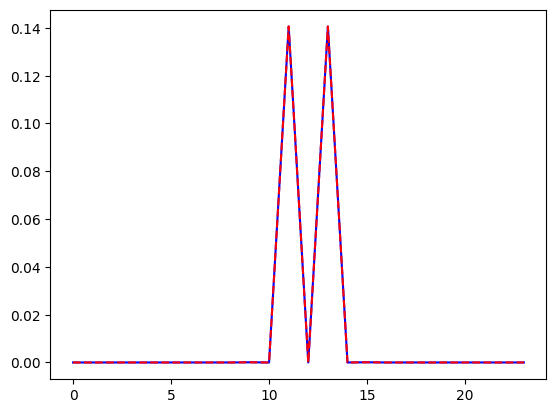

In [ ]:
s_ = np.s_[n * NH - 12 : n * NH + 12]

print("Absolute differences in Fourier coefficients")
print(abs(ti_z - hb_z)[s_], "\n")

print("TI coefficients")
print(abs(ti_z)[s_], "\n")

print("HB coefficients")
print(abs(hb_z)[s_])

plt.plot(abs(ti_z)[s_], color="blue")
plt.plot(abs(hb_z)[s_], color="red", ls="--")
plt.show()

Differences in real parts of Fourier coefficients
[-6.88635942e-11 -5.96293155e-11 -5.45669420e-11 -5.33584111e-11
 -5.24120092e-11 -5.80688372e-11 -6.25362567e-11 -5.83523365e-11
 -5.33665789e-11 -5.55612355e-11 -6.20195701e-11 -2.12063631e-10
 -2.18312937e-09 -2.12063631e-10 -6.20195701e-11 -5.55612355e-11
 -5.33665789e-11 -5.83523365e-11 -6.25362567e-11 -5.80688372e-11
 -5.24120092e-11 -5.33584111e-11 -5.45669420e-11 -5.96293155e-11] 

Real parts of TI coefficients
[-6.88635942e-11 -5.96293215e-11 -5.45669420e-11 -5.33731220e-11
 -5.24120092e-11 -5.38183478e-11 -6.25362567e-11  4.65024454e-08
 -5.33665789e-11  2.99481139e-05 -6.20195698e-11 -1.16254456e-01
 -2.18312937e-09 -1.16254456e-01 -6.20195698e-11  2.99481139e-05
 -5.33665789e-11  4.65024454e-08 -6.25362567e-11 -5.38183478e-11
 -5.24120092e-11 -5.33731220e-11 -5.45669420e-11 -5.96293215e-11] 

Real parts of HB coefficients
[-3.32720477e-22 -6.04711008e-18  6.00830393e-22 -1.47108497e-14
 -7.42924512e-22  4.25048946e-12  3.645

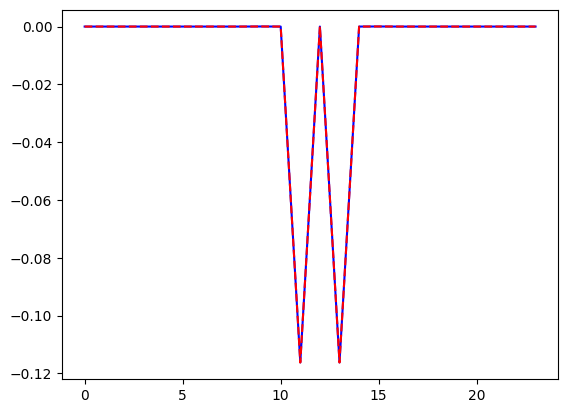

In [ ]:
s_ = np.s_[n * NH - 12 : n * NH + 12]

print("Differences in real parts of Fourier coefficients")
print((ti_z - hb_z).real[s_], "\n")

print("Real parts of TI coefficients")
print((ti_z).real[s_], "\n")

print("Real parts of HB coefficients")
print((hb_z).real[s_])

plt.plot(ti_z.real[s_], color="blue")
plt.plot(hb_z.real[s_], color="red", ls="--")
plt.show()

Differences in imaginary parts of Fourier coefficients
[-9.36569289e-11 -9.22172025e-11 -8.84930366e-11 -1.12306504e-10
 -1.39959586e-10 -1.57051447e-10 -1.78339976e-10 -2.13007960e-10
 -2.75923787e-10 -3.86221232e-10 -5.85104965e-10 -1.41843613e-09
  7.04295016e-27  1.41843613e-09  5.85104965e-10  3.86221232e-10
  2.75923787e-10  2.13007960e-10  1.78339976e-10  1.57051447e-10
  1.39959586e-10  1.12306504e-10  8.84930366e-11  9.22172025e-11] 

Imaginary parts of TI coefficients
[-9.36569289e-11 -9.22171952e-11 -8.84930366e-11 -1.12313152e-10
 -1.39959586e-10 -1.84256686e-10 -1.78339976e-10 -5.63500546e-09
 -2.75923787e-10  7.25830687e-05 -5.85104964e-10  7.90669389e-02
 -0.00000000e+00 -7.90669389e-02  5.85104964e-10 -7.25830687e-05
  2.75923787e-10  5.63500546e-09  1.78339976e-10  1.84256686e-10
  1.39959586e-10  1.12313152e-10  8.84930366e-11  9.22171952e-11] 

Imaginary parts of HB coefficients
[ 8.71938839e-22  7.27428464e-18 -8.29481209e-22 -6.64752532e-15
 -1.27509891e-21 -2.7205

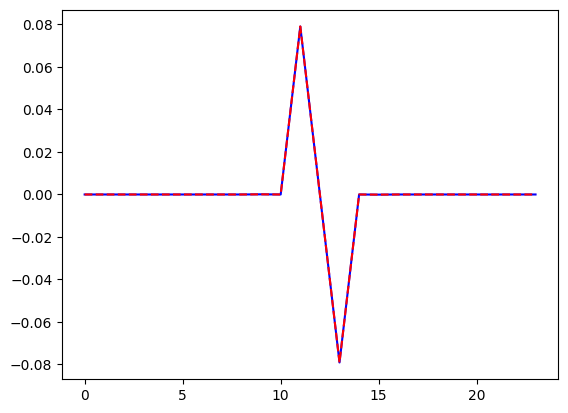

In [ ]:
s_ = np.s_[n * NH - 12 : n * NH + 12]

print("Differences in imaginary parts of Fourier coefficients")
print((ti_z - hb_z).imag[s_], "\n")

print("Imaginary parts of TI coefficients")
print((ti_z).imag[s_], "\n")

print("Imaginary parts of HB coefficients")
print((hb_z).imag[s_])

plt.plot(ti_z.imag[s_], color="blue")
plt.plot(hb_z.imag[s_], color="red", ls="--")
plt.show()

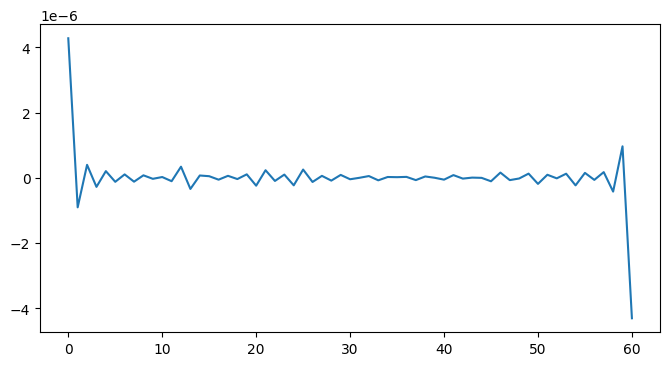

In [ ]:
ti_zpp = freq.get_derivative(omega, ti_z, NH, n, 2)
ti_zzpp = utils.extract_dofs_freq(ti_zpp, n)
ti_xxpp = scipy.fft.ifft(
    scipy.fft.ifftshift(ti_zzpp, axes=1), axis=1, norm=freq.FFT_NORM
).real

ti_res = utils.get_time_residual(
    ti_xx, ti_xxp, ti_xxpp, M, C, K, f_ext, f_nl, omega, tls, n
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(ti_res[0])

plt.show()

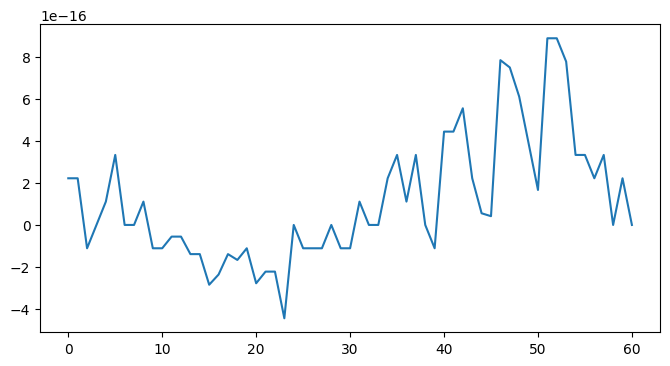

In [ ]:
hb_zpp = freq.get_derivative(omega, hb_zp, NH, n, 1)
hb_zzpp = utils.extract_dofs_freq(hb_zpp, n)
hb_xxpp = scipy.fft.ifft(
    scipy.fft.ifftshift(hb_zzpp, axes=1), axis=1, norm=freq.FFT_NORM
).real

hb_res = utils.get_time_residual(
    hb_xx, hb_xxp, hb_xxpp, M, C, K, f_ext, f_nl, omega, tls, n
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(hb_res[0])

plt.show()